In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ASASM import mdft, midft
import torch
import math

/home/hywei/anaconda3/envs/sampling/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
zf = 0.0357
z = 0.01

In [23]:
def mdft1d(in_matrix, x, fx):
    x = x.unsqueeze(-1)
    fx = fx.unsqueeze(-2)
    mx = torch.exp(-2 * torch.pi * 1j * torch.matmul(x, fx))
    out_matrix = torch.matmul(in_matrix, mx)

    lx = torch.numel(x)
    if lx == 1:
        dx = 1
    else:
        dx = (torch.squeeze(x)[-1] - torch.squeeze(x)[0]) / (lx - 1)

    out_matrix = out_matrix * dx  # the result is only valid for uniform sampling
    return out_matrix

In [39]:
r = 1
a = 0.001

# spat
tau_amp = np.exp(-a * r**2) * 2 * a * r / np.pi
tau_phi = 100 / np.pi
Ns = math.ceil((tau_amp) * (2 * r))
tau_spat = Ns / (2 * r)
x = np.linspace(-r, r, Ns)
print(Ns)

# freq
fxmax = tau_spat / 2
Nf = 1000
fx = np.linspace(-fxmax, fxmax, Nf)

1


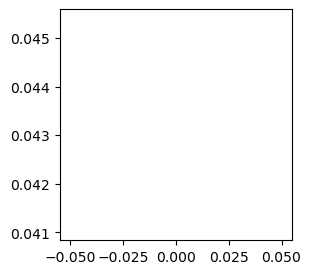

In [30]:
u0 = np.exp(- np.pi * x**2) * np.exp(1j * x)
plt.figure(figsize=(3,3))
plt.plot(np.abs(u0))

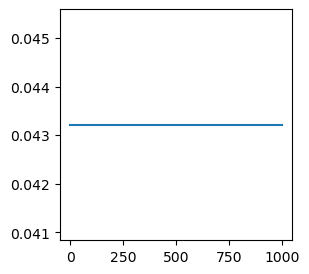

In [31]:
u1 = mdft1d(torch.as_tensor(u0), torch.as_tensor(x), torch.as_tensor(fx))
plt.figure(figsize=(3,3))
plt.plot(np.abs(u1))

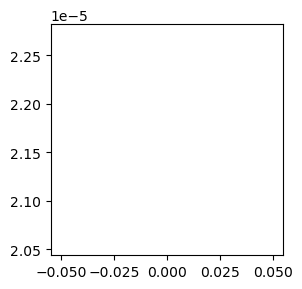

In [32]:
u2 = mdft1d(torch.as_tensor(u1), torch.as_tensor(fx), torch.as_tensor(x))
plt.figure(figsize=(3,3))
plt.plot(np.abs(u2))

In [ ]:
d = 35e-3
zf = 1 / (1/d - 1/1.7)
dv = 5000e-3
l1 = dv - zf
l2 = 1 / (1/dv - 1/l1)
lam = 500e-9
k = 2 * np.pi / lam
D = d / 16

In [ ]:
Ns = 50
dx = D / Ns
x = torch.linspace(-D/2, D/2, Ns)
xx, yy = torch.meshgrid(x, x, indexing='xy')

fx = torch.linspace(-1/(2*dx), 1/(2*dx), 1000)
fxx, fyy = torch.meshgrid(fx, fx, indexing='xy')
pupil = torch.where(xx**2 + yy**2 <= (D/2)**2, 1., 0.)

In [ ]:
phi_U = k * torch.sqrt((lam*dv*fxx)**2 + (lam*dv*fyy)**2 + (dv-l2)**2)
U = torch.exp(1j * phi_U) / (1j * lam * dv)
plt.figure(figsize=(3,3))
plt.imshow(torch.angle(U))

In [ ]:
radius = np.sqrt(1.7**2 + (xx - 0)**2 + (yy - 0)**2)
phi_u = k * radius
u = pupil / radius * np.exp(1j * phi_u)
# plt.figure(figsize=(3,3))
# plt.imshow(torch.angle(u))

In [ ]:
Fu = mdft(u, x, x, fx.unsqueeze(0), fx.unsqueeze(0))
plt.figure(figsize=(3,3))
plt.imshow(torch.angle(Fu[0]))

In [ ]:
#gradient
def h(fx):
    h = k*zf*lam**2 * fx / np.sqrt(1 + (lam*zf/dv)**2 * (fx**2+fx**2))
    return h
plt.figure(figsize=(3,3))
plt.plot(h(fx))

In [ ]:
z = zf*1
theta = 0
xc = - z * np.sin(theta / 180 * np.pi) / np.sqrt(1 - np.sin(theta / 180 * np.pi)**2 - np.sin(theta / 180 * np.pi)**2)
def g(fx):
    fxs = fx - np.sin(theta/180*torch.pi) / lam
    g = -k*z*lam**2*fxs / np.sqrt(1 - (lam*fxs)**2 - (lam*fx)**2)
    return g
plt.figure(figsize=(3,3))
plt.plot(g(fx))

In [ ]:
plt.figure(figsize=(3,3))
plt.plot(h(fx)+g(fx))

In [ ]:
def monotonic(L):
    non_increasing = all(x>=y for x, y in zip(L, L[1:]))
    non_decreasing = all(x<=y for x, y in zip(L, L[1:]))
    return non_increasing or non_decreasing
monotonic(h(fx)+g(fx))

In [ ]:
FcH = 1 / (4*torch.pi) * (g(-1/dx/2) + g(1/dx/2) + xc)
FbUH = 1 / (2*torch.pi) * (max(h(fx)+g(fx)) - min(h(fx)+g(fx)))
FbU = (h(fx).max() - h(fx).min()) / (2*torch.pi)
FbH = (g(fx).max() - g(fx).min()) / (2*torch.pi)

In [ ]:
2*abs(FcH) + FbUH < max(2*abs(FcH) + FbH, FbU)

In [ ]:
FbH

In [ ]:
FbU

In [ ]:
FbUH

In [ ]:
abs(FbH - FbU)